<a href="https://colab.research.google.com/github/MegumuTsukamoto/Research_and_Development/blob/main/%E7%94%BB%E5%83%8F%E5%88%86%E9%A1%9E_CNN_LSTM.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# import numpy as np
# import tensorflow as tf
# import matplotlib.pyplot as plt
# from keras.datasets import mnist

In [1]:
import numpy as np
import matplotlib.pyplot as plt

# PyTorch系のライブラリ
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

# MNISTを落とすために使っただけだから不要
import torchvision
import torchvision.transforms as transforms

In [2]:
# ダミーデータ（(28,28)サイズの画像）

#訓練データ
train_dataset = torchvision.datasets.MNIST(root='./data',
                                           train=True,
                                           transform=transforms.ToTensor(),
                                           download = True)
#検証データ
test_dataset = torchvision.datasets.MNIST(root='./data',
                                           train=False,
                                           transform=transforms.ToTensor(),
                                           download = True)


Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 9912422/9912422 [00:01<00:00, 7145663.03it/s] 


Extracting ./data/MNIST/raw/train-images-idx3-ubyte.gz to ./data/MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 28881/28881 [00:00<00:00, 1023312.95it/s]


Extracting ./data/MNIST/raw/train-labels-idx1-ubyte.gz to ./data/MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 1648877/1648877 [00:00<00:00, 9837193.59it/s]


Extracting ./data/MNIST/raw/t10k-images-idx3-ubyte.gz to ./data/MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 4542/4542 [00:00<00:00, 4183251.82it/s]

Extracting ./data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/MNIST/raw



In [3]:
# 学習用：検証用=60,000：10,000
print(len(train_dataset))
print(len(test_dataset))
print(type(train_dataset))

60000
10000
<class 'torchvision.datasets.mnist.MNIST'>


画像サイズ : torch.Size([1, 28, 28])
ラベル : 7


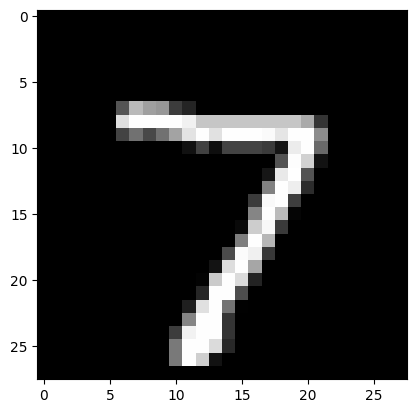

In [4]:
x_train, y_train = test_dataset[0]

# 白黒なのでチャンネル数は1
print("画像サイズ : {}".format(x_train.size()))
print("ラベル : {}".format(y_train))
plt.imshow(x_train.view(-1,28), cmap='gray')

In [5]:
# バッチ学習させるために、データローダーでランダムにピックアップ

batch_size=64

train_loader = torch.utils.data.DataLoader(dataset=train_dataset,
                                           batch_size=batch_size,
                                           shuffle=True)

test_loader = torch.utils.data.DataLoader(dataset=test_dataset,
                                           batch_size=batch_size,
                                           shuffle=True)


In [6]:
for x_train, y_train in train_loader:
  # バッチサイズ個の画像データ、ラベルを返す
  print(x_train.size())
  print(len(y_train))
  print(y_train)
  break

torch.Size([64, 1, 28, 28])
64
tensor([6, 0, 2, 9, 9, 1, 3, 0, 1, 7, 5, 0, 3, 0, 6, 2, 3, 6, 4, 2, 8, 9, 1, 7,
        3, 0, 6, 9, 5, 3, 2, 8, 7, 8, 8, 9, 4, 2, 5, 2, 8, 8, 4, 9, 4, 4, 3, 5,
        2, 9, 1, 1, 7, 2, 9, 1, 7, 0, 2, 7, 0, 7, 9, 9])


In [8]:
# MNISTから時系列データを作るための関数

# 系列長
sequence_size=6
# 画像サイズ（縦、横）
img_size=28
# 出力サイズ（今は0〜9を6回足すので、出力である和は0〜54の55通り）
output_size=55


def sequence_data(x, y):
  x_T = []
  y_T = []
  for _ in range(sequence_size):
    x_batch=[]
    y_batch=[]
    for i in range(batch_size):
        step = np.random.randint(0, x.size(0))
        # x batch
        x_step = x[step]
        x_step = np.reshape(x_step, [img_size, img_size, 1])
        x_step = np.reshape(x_step, [1, img_size, img_size])
        x_batch.append(x_step.tolist())
        # y batch
        y_step = int(y[step])
        y_batch.append(y_step)

    # x list of sequence
    x_T.append(x_batch)
    # y list of sequence
    y_T.append(y_batch)

  # 0〜9を6回足す
  y_T=np.asarray(y_T[0])+np.asarray(y_T[1])+np.asarray(y_T[2]) \
        +np.asarray(y_T[3])+np.asarray(y_T[4])+np.asarray(y_T[5])

  return x_T, y_T


In [9]:
# 関数の確認
for x_test, y_test in test_loader:
  x_T, y_T = sequence_data(x_test, y_test)
  x_T = torch.tensor(x_T)
  y_T = torch.tensor(y_T)
  print(x_T.size())
  print(y_T.size())
  break

torch.Size([6, 64, 1, 28, 28])
torch.Size([64])


y_T tensor([10, 24, 17, 38])


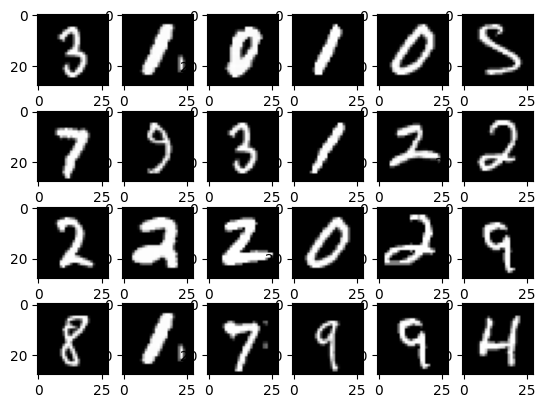

In [10]:
# 先頭の数セットを可視化

num = 4
print('y_T',y_T[:num])

for i in range(num):
    # time series 1
    plt.subplot(num, 6, 6 * i + 1)
    img1 = np.reshape(x_T[0][i], [img_size, img_size])
    plt.imshow(img1)
    plt.gray()
    # time series 2
    plt.subplot(num, 6, 6 * i + 2)
    img2 = np.reshape(x_T[1][i], [img_size, img_size])
    plt.imshow(img2)
    plt.gray()
    # time series 3
    plt.subplot(num, 6, 6 * i + 3)
    img3 = np.reshape(x_T[2][i], [img_size, img_size])
    plt.imshow(img3)
    plt.gray()
    # time series 4
    plt.subplot(num, 6, 6 * i + 4)
    img4 = np.reshape(x_T[3][i], [img_size, img_size])
    plt.imshow(img4)
    plt.gray()
    # time series 5
    plt.subplot(num, 6, 6 * i + 5)
    img5 = np.reshape(x_T[4][i], [img_size, img_size])
    plt.imshow(img5)
    plt.gray()
    # time series 6
    plt.subplot(num, 6, 6 * i + 6)
    img6 = np.reshape(x_T[5][i], [img_size, img_size])
    plt.imshow(img6)
    plt.gray()

plt.show()

In [ ]:
# 上でダミーデータを作ったが、要は画像データがtensor.size([系列長、バッチサイズ、チャンネル数、縦サイズ、横サイズ])、ラベルがtensor.size([バッチサイズ])を用意すればいい
# チャンネル数は、白黒なら１

In [11]:
# CNN＝＞RNN（LSTM）のモデル
class CRNN_Model(nn.Module):

  def __init__(self, hidden_size, batch_size, sequence_size, img_size,output_size, device):
    self.hidden_size=hidden_size
    self.batch_size=batch_size
    self.sequence_size=sequence_size
    self.output_size=output_size
    self.device = device

    super(CRNN_Model, self).__init__()

    # cnn
    self.cnn = nn.Sequential(
    nn.Conv2d(1, self.batch_size, kernel_size=1, stride=1, padding=1),
    nn.MaxPool2d(kernel_size=2, stride=2),
    nn.Conv2d(self.batch_size, 1, kernel_size=1, stride=1, padding=1),
    nn.MaxPool2d(kernel_size=2, stride=2),
    nn.Flatten(),
    nn.Linear(64, self.hidden_size)
    )

    # lstm
    self.lstm = nn.LSTM(input_size=self.hidden_size, hidden_size=32 ,num_layers=1)
    self.fc = nn.Linear(32, self.output_size)



  def forward(self, x):
    # cnn
    hidden_list=[]
    for i in range(self.sequence_size):
      hidden = self.cnn(x[i])
      hidden_list.append(hidden.tolist())
    hidden_list = torch.tensor(hidden_list)

    # lstm
    x0 = hidden_list.to(device)
    xt, _ = self.lstm(x0) # size:(sequence_size, batch_size, 32)
    xt = xt[-1, :, :] # size:(batch_size, 32)
    xt = self.fc(xt)  # size:(batch_size, output_size)

    return xt


In [12]:
# 、モデルやデータをGPU（cuda）にのせる
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(device)

# LSTMの隠れ層のサイズ（ハイパーパラメータ）
hidden_size=256
# 出力サイズ（今は0〜9を6回足すので、出力である和は0〜54の55通り）
output_size = 55

net = CRNN_Model(hidden_size, batch_size, sequence_size, img_size,output_size, device).to(device)
print(net)

# 今は分類なので損失関数はクロスエントロピー
criterion = nn.CrossEntropyLoss()
# 最適化アルゴリズムは確率的勾配降下法
optimizer = optim.SGD(net.parameters(), lr=0.01, momentum=0.9, weight_decay=5e-4)

cpu
CRNN_Model(
  (cnn): Sequential(
    (0): Conv2d(1, 64, kernel_size=(1, 1), stride=(1, 1), padding=(1, 1))
    (1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (2): Conv2d(64, 1, kernel_size=(1, 1), stride=(1, 1), padding=(1, 1))
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (4): Flatten(start_dim=1, end_dim=-1)
    (5): Linear(in_features=64, out_features=256, bias=True)
  )
  (lstm): LSTM(256, 32)
  (fc): Linear(in_features=32, out_features=55, bias=True)
)


In [13]:
# サイズの確認
for x_train, y_train in train_loader:
  x_T, y_T = sequence_data(x_train, y_train)
  x_T = torch.tensor(x_T)
  y_T = torch.tensor(y_T)
  x_T, y_T = x_T.to(device), y_T.to(device)
  print(x_T.size())
  print(y_T.size())
  outputs = net(x_T)
  break

print(outputs.size())

torch.Size([6, 64, 1, 28, 28])
torch.Size([64])
torch.Size([64, 55])


In [ ]:
# エポック数（ハイパーパラメータ）
num_epochs = 20

# 学習
train_loss_list = []
train_acc_list = []
val_loss_list = []
val_acc_list = []

for epoch in range(num_epochs):
    train_loss = 0
    train_acc = 0
    val_loss = 0
    val_acc = 0

    #train
    net.train()
    for i, (x_train, y_train) in enumerate(train_loader):
        #view()での変換をしない
        images, labels = sequence_data(x_train, y_train)
        images = torch.tensor(images)
        labels = torch.tensor(labels)
        images, labels = images.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = net(images)
        loss = criterion(outputs, labels)
        train_loss += loss.item()
        train_acc += (outputs.max(1)[1] == labels).sum().item()
        loss.backward()
        optimizer.step()

    avg_train_loss = train_loss / len(train_loader)
    avg_train_acc = train_acc / len(train_loader.dataset)

    #val
    net.eval()
    with torch.no_grad():
        for x_test, y_test in test_loader:
            #view()での変換をしない
            images, labels = sequence_data(x_test, y_test)
            images = torch.tensor(images)
            labels = torch.tensor(labels)
            images, labels = images.to(device), labels.to(device)

            outputs = net(images)
            loss = criterion(outputs, labels)
            val_loss += loss.item()
            val_acc += (outputs.max(1)[1] == labels).sum().item()
    avg_val_loss = val_loss / len(test_loader)
    avg_val_acc = val_acc / len(test_loader.dataset)

    print ('Epoch [{}/{}], Loss: {loss:.4f}, val_loss: {val_loss:.4f}, val_acc: {val_acc:.4f}'
           .format(epoch+1, num_epochs, i+1, loss=avg_train_loss, val_loss=avg_val_loss, val_acc=avg_val_acc))
    train_loss_list.append(avg_train_loss)
    train_acc_list.append(avg_train_acc)
    val_loss_list.append(avg_val_loss)
    val_acc_list.append(avg_val_acc)

Epoch [1/20], Loss: 3.4940, val_loss: 3.4148, val_acc: 0.0510
Epoch [2/20], Loss: 3.4172, val_loss: 3.4254, val_acc: 0.0520
Epoch [3/20], Loss: 3.4153, val_loss: 3.4227, val_acc: 0.0496
Epoch [4/20], Loss: 3.4181, val_loss: 3.4309, val_acc: 0.0532
Epoch [5/20], Loss: 3.4081, val_loss: 3.4176, val_acc: 0.0498
Epoch [6/20], Loss: 3.4213, val_loss: 3.4291, val_acc: 0.0483
Epoch [7/20], Loss: 3.4153, val_loss: 3.4271, val_acc: 0.0531
Epoch [8/20], Loss: 3.4172, val_loss: 3.4218, val_acc: 0.0510
Epoch [9/20], Loss: 3.4173, val_loss: 3.4213, val_acc: 0.0558
Epoch [10/20], Loss: 3.4132, val_loss: 3.4216, val_acc: 0.0494
Epoch [11/20], Loss: 3.4201, val_loss: 3.4182, val_acc: 0.0560
Epoch [12/20], Loss: 3.4178, val_loss: 3.4231, val_acc: 0.0537
Epoch [13/20], Loss: 3.4179, val_loss: 3.4140, val_acc: 0.0515
Epoch [14/20], Loss: 3.4251, val_loss: 3.4160, val_acc: 0.0511
Epoch [15/20], Loss: 3.4189, val_loss: 3.4133, val_acc: 0.0518
Epoch [16/20], Loss: 3.4175, val_loss: 3.4172, val_acc: 0.0491
E

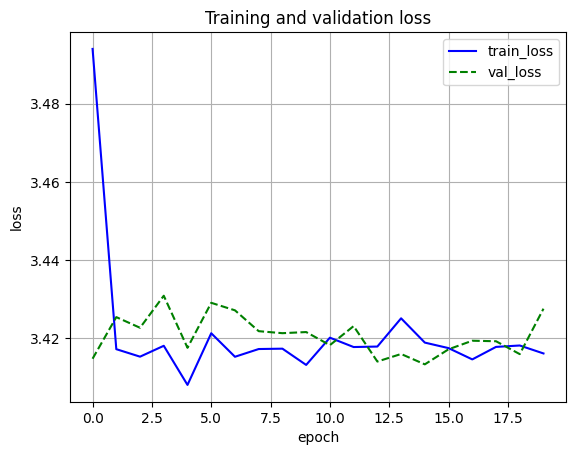

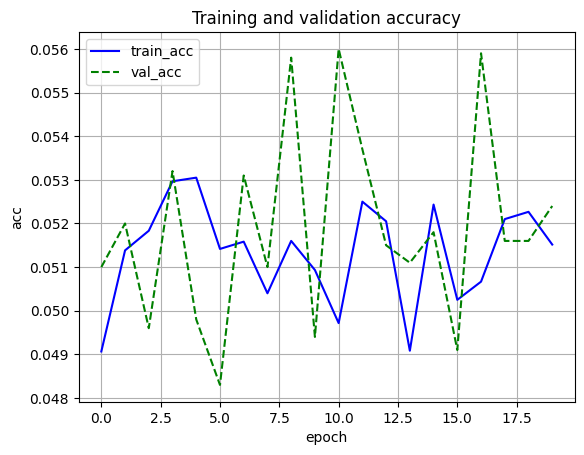

In [ ]:
import matplotlib.pyplot as plt
%matplotlib inline

plt.figure()
plt.plot(range(num_epochs), train_loss_list, color='blue', linestyle='-', label='train_loss')
plt.plot(range(num_epochs), val_loss_list, color='green', linestyle='--', label='val_loss')
plt.legend()
plt.xlabel('epoch')
plt.ylabel('loss')
plt.title('Training and validation loss')
plt.grid()

plt.figure()
plt.plot(range(num_epochs), train_acc_list, color='blue', linestyle='-', label='train_acc')
plt.plot(range(num_epochs), val_acc_list, color='green', linestyle='--', label='val_acc')
plt.legend()
plt.xlabel('epoch')
plt.ylabel('acc')
plt.title('Training and validation accuracy')
plt.grid()